In [142]:
import xgboost as xgb
import pandas as pd
import sqlalchemy
import yahooquery as yq
from sklearn.model_selection import GridSearchCV
import numpy as np

import matplotlib.pyplot as plt

In [2]:
engine = sqlalchemy.create_engine('sqlite:///' + "Financial.db", execution_options={"sqlite_raw_colnames": True})
df_financial = pd.read_sql_table('FinancialDataJoined', engine)

engine = sqlalchemy.create_engine('sqlite:///' + "SEC_Filings.db", execution_options={"sqlite_raw_colnames": True})
df_sentiments = pd.read_sql_table('Aggregated_Sentiment_Scores', engine)
df_SIC = pd.read_sql_table("10K_Data", engine)
df_SIC = df_SIC[['SIC', 'CIK']]

agri = ['0100', '0200', '0900']
fin = ['6172', '6199', '6200', '6211', '6221', '6282']
air = ['4513', '4522', '4581']
bank = ['6022', '6029', '6035', '6036', '6099']

df_SIC['Industry'] = ''
df_SIC.loc[df_SIC['SIC'].isin(agri), 'Industry'] = "Agriculture"
df_SIC.loc[df_SIC['SIC'].isin(fin), 'Industry'] = "Financial Services"
df_SIC.loc[df_SIC['SIC'].isin(air), 'Industry'] = "Aviation"
df_SIC.loc[df_SIC['SIC'].isin(bank), 'Industry'] = "Banking"

In [143]:
tab = df_SIC.merge(df_sentiments, on="Industry", how="left")

df_pivot = pd.pivot_table(tab, values='Aggregated Sentiment', index=['CIK', 'Year'], 
                          columns=['Aspect'], fill_value=0).reset_index(drop=False)
ind = tab[['CIK', 'Year', 'Industry']].drop_duplicates(ignore_index=True)

df_pivot = ind.merge(df_pivot, on=['CIK', 'Year'])
df_financial['Year'] = df_financial['asOfDate'].dt.year+1
df_pivot_joined = df_pivot.merge(df_financial, on=['CIK', 'Year'])

ticker = df_pivot_joined.pop('Ticker')
company  = df_pivot_joined.pop('Company')

df_pivot_joined.insert(1, 'Company', company)
df_pivot_joined.insert(2, 'Ticker', ticker)
df_pivot_joined.drop('asOfDate', axis=1, inplace=True)
df_pivot_joined['BTM'] = df_pivot_joined['TangibleBookValue']/df_pivot_joined['TotalCapitalization']
df_pivot_joined['Gearing'] = df_pivot_joined['TotalDebt']/df_pivot_joined['TotalAssets']
df_pivot_joined['CashToAssets'] = df_pivot_joined['CashAndCashEquivalents']/df_pivot_joined['TotalAssets']
df_pivot_joined['logMktCap'] = df_pivot_joined['TotalCapitalization'].apply(np.log)

df_pivot_joined.drop(['TangibleBookValue', 'TotalCapitalization','TotalDebt', 'TotalAssets', 'CashAndCashEquivalents'], axis=1, inplace=True)

In [155]:
df_financial.loc[df_financial['CIK']=='0001435181']

,CIK,Company,Ticker,asOfDate,BasicEPS,CashAndCashEquivalents,TotalAssets,TotalDebt,TangibleBookValue,TotalCapitalization,Year
1081,0001435181,Pharmagreen Biotech Inc.,PHBI,2019-09-30,-0.010000,62682.0,630272.0,76704.0,-833224.0,-831625.0,2020
1082,0001435181,Pharmagreen Biotech Inc.,PHBI,2020-09-30,-0.030000,12196.0,266245.0,714553.0,-2887600.0,-2854124.0,2021
1083,0001435181,Pharmagreen Biotech Inc.,PHBI,2021-09-30,-0.020000,25300.0,373081.0,270200.0,-1646052.0,-1606676.0,2022
1084,0001435181,Pharmagreen Biotech Inc.,PHBI,2022-09-30,-0.002168,8016.0,208971.0,338588.0,-1775974.0,-1656491.0,2023


In [144]:
df_pivot_joined

,CIK,Company,Ticker,Year,Industry,algorithm,artificial intelligence,automation,bots,machine learning,BasicEPS,BTM,Gearing,CashToAssets,logMktCap
0,0001531031,"Esquire Financial Holdings, Inc.",ESQ,2020,Banking,0.318409,0.000000,0.243711,0.000000,0.000000,1.91,0.999226,0.000108,0.077450,18.526373
1,0001531031,"Esquire Financial Holdings, Inc.",ESQ,2021,Banking,0.312070,0.492463,0.345938,0.138467,0.000000,1.70,0.999611,0.000052,0.069589,18.652784
2,0001531031,"Esquire Financial Holdings, Inc.",ESQ,2022,Banking,0.327686,0.640856,0.407673,0.243714,0.717550,2.40,1.139623,0.000042,0.126535,18.652784
3,0001531031,"Esquire Financial Holdings, Inc.",ESQ,2023,Banking,0.321426,0.577837,0.370036,0.000000,0.598433,2.40,1.253978,0.000035,0.117596,18.652784
4,0001050743,PEAPACK GLADSTONE FINANCIAL CORP,PGC,2020,Banking,0.318409,0.000000,0.243711,0.000000,0.000000,2.46,0.669101,0.064933,0.040148,20.355196
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1548,0001603978,"AquaBounty Technologies, Inc.",AQB,2022,Agriculture,0.000000,0.597137,0.326169,0.000000,0.000000,-0.32,0.960620,0.041039,0.387220,19.219656
1549,0001603978,"AquaBounty Technologies, Inc.",AQB,2023,Agriculture,0.000000,0.581018,0.284989,0.000000,0.000000,-0.32,0.967185,0.041510,0.475300,19.104823
1550,0001465470,NaturalShrimp Inc,SHMP,2022,Agriculture,0.000000,0.597137,0.326169,0.000000,0.000000,-0.01,0.297844,0.533187,0.010238,16.176729
1551,0001465470,NaturalShrimp Inc,SHMP,2023,Agriculture,0.000000,0.581018,0.284989,0.000000,0.000000,-0.16,-3.172323,0.096214,0.045755,16.573372


In [145]:
df_stock = pd.DataFrame()

for ticker in df_pivot_joined['Ticker'].unique():
    tick = yq.Ticker(ticker)
    df_stock = pd.concat([df_stock, tick.history(start='01-01-2019', interval='3mo')[0::4]], axis=0)

df_stock = df_stock.pop("adjclose").reset_index(drop=False)
df_stock["Year"] = df_stock["date"].apply(lambda x: x.year)
df_stock.pop("date")

# log return?
for ticker in df_stock['symbol'].unique():
    df_stock.loc[df_stock['symbol']==ticker, 'Return'] = df_stock.loc[df_stock['symbol']==ticker, 'adjclose'].pct_change()

df_stock.dropna(inplace=True)
df_stock.drop('adjclose', axis=1, inplace=True)
df_stock = df_stock.rename(columns={"symbol": "Ticker"})

In [151]:
df_pivot_joined.loc[df_pivot_joined['logMktCap'].isna()]

,CIK,Company,Ticker,Year,Industry,algorithm,artificial intelligence,automation,bots,machine learning,BasicEPS,BTM,Gearing,CashToAssets,logMktCap
1081,0001435181,Pharmagreen Biotech Inc.,PHBI,2022,Aviation,0.537583,0.000000,0.132717,0.000000,0.000000,-0.020000,1.024508,0.724240,0.067814,NaN
1082,0001435181,Pharmagreen Biotech Inc.,PHBI,2023,Aviation,0.369800,0.000000,0.132717,0.000000,0.000000,-0.002168,1.072130,1.620263,0.038359,NaN
1083,0001435181,Pharmagreen Biotech Inc.,PHBI,2020,Aviation,0.000000,0.000000,0.227908,0.000000,0.000000,-0.010000,1.001923,0.121700,0.099452,NaN
1084,0001435181,Pharmagreen Biotech Inc.,PHBI,2021,Aviation,0.000000,0.000000,0.171992,0.000000,0.000000,-0.030000,1.011729,2.683818,0.045807,NaN
1089,0001386044,"Freedom Holdings, Inc.",FHLD,2021,Financial Services,0.239638,0.330371,0.381553,0.666155,0.411042,-0.220000,6.041222,5345.000000,1.000000,NaN
1090,0001386044,"Freedom Holdings, Inc.",FHLD,2022,Financial Services,0.263436,0.401637,0.365664,0.796456,0.380215,-0.240000,1.383629,45.465760,1.000000,NaN
1091,0001386044,"Freedom Holdings, Inc.",FHLD,2023,Financial Services,0.252538,0.384241,0.375821,0.000000,0.287640,-0.000385,1.287893,699.056497,1.000000,NaN
1100,0001144879,Applied Digital Corp.,APLD,2021,Financial Services,0.239638,0.330371,0.381553,0.666155,0.411042,-0.015906,3.590074,inf,NaN,NaN
1101,0001144879,Applied Digital Corp.,APLD,2022,Financial Services,0.263436,0.401637,0.365664,0.796456,0.380215,-0.380000,3.020519,0.141842,0.780627,NaN
1110,0001510832,Biopower Operations Corp,BOPO,2020,Financial Services,0.229076,0.309275,0.474241,0.667073,0.316911,-0.003010,1.000000,inf,NaN,NaN


In [146]:
df_train = df_pivot_joined.merge(df_stock, on=['Ticker', 'Year'])
df_train.drop(["CIK", "Company", "Ticker"], axis=1, inplace=True)
Return = df_train.pop("Return")

df_train = pd.get_dummies(df_train, drop_first=True)

In [147]:
model_xgb = xgb.XGBRegressor()

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 10],
    'n_estimators': [50, 100, 200]
}

grid_search = GridSearchCV(estimator=model_xgb, param_grid=param_grid, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
grid_search.fit(df_train, Return)
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_:.3f}")

c:\Users\Gavin\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
135 fits failed out of a total of 135.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
135 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Gavin\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Gavin\Anaconda3\lib\site-packages\xgboost\core.py", line 620, in inner_f
    return func(**kwargs)
  File "c:\Users\Gavin\Anaconda3\lib\site-packages\xgboost\sklearn.py", line 988, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "c:\Users\Gavin\Anaconda3\lib\site-packag

XGBoostError: [10:19:14] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\data\data.cc:1104: Check failed: valid: Input data contains `inf` or `nan`

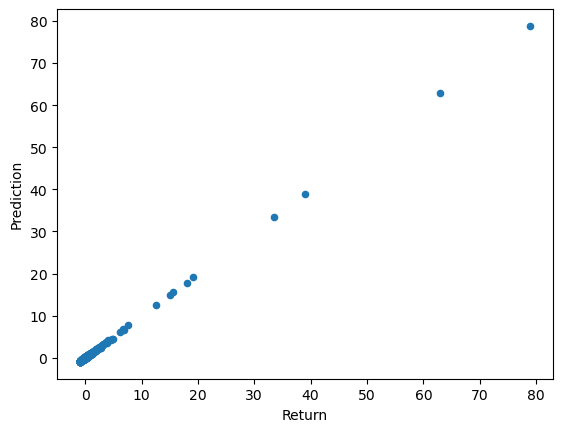

In [124]:
df.plot(kind='scatter', x='Return', y="Prediction")
plt.show()

In [ ]:
xgb.plot_importance(model, color=colors_hex[0])
plt.show()

In [133]:
df_train

,Year,algorithm,artificial intelligence,automation,bots,machine learning,BasicEPS,CashAndCashEquivalents,TotalAssets,TotalDebt,TangibleBookValue,TotalCapitalization,Industry_Aviation,Industry_Banking,Industry_Financial Services
0,2020,0.318409,0.000000,0.243711,0.000000,0.000000,1.91,61806000.0,7.980080e+08,86000.0,111062000.0,111148000.0,0,1,0
1,2021,0.312070,0.492463,0.345938,0.138467,0.000000,1.70,65185000.0,9.367140e+08,49000.0,126076000.0,126125000.0,0,1,0
2,2022,0.327686,0.640856,0.407673,0.243714,0.717550,2.40,149156000.0,1.178770e+09,49000.0,143735000.0,126125000.0,0,1,0
3,2023,0.321426,0.577837,0.370036,0.000000,0.598433,2.40,164122000.0,1.395639e+09,49000.0,158158000.0,126125000.0,0,1,0
4,2020,0.318409,0.000000,0.243711,0.000000,0.000000,2.46,208083000.0,5.182879e+09,336538000.0,463064000.0,692069000.0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,2022,0.000000,0.597137,0.326169,0.000000,0.000000,-0.32,88454988.0,2.284360e+08,9374756.0,213570921.0,222326096.0,0,0,0
1457,2023,0.000000,0.581018,0.284989,0.000000,0.000000,-0.32,101638557.0,2.138408e+08,8876567.0,191702904.0,198207152.0,0,0,0
1458,2022,0.000000,0.597137,0.326169,0.000000,0.000000,-0.01,155795.0,1.521694e+07,8113476.0,3158298.0,10603862.0,0,0,0
1459,2023,0.000000,0.581018,0.284989,0.000000,0.000000,-0.16,1734040.0,3.789861e+07,3646392.0,-50015142.0,15766093.0,0,0,0


In [140]:
print(df_train.iloc[:1100,:], Return.iloc[:1100])

      Year  algorithm  artificial intelligence  automation      bots  \
0     2020   0.318409                 0.000000    0.243711  0.000000   
1     2021   0.312070                 0.492463    0.345938  0.138467   
2     2022   0.327686                 0.640856    0.407673  0.243714   
3     2023   0.321426                 0.577837    0.370036  0.000000   
4     2020   0.318409                 0.000000    0.243711  0.000000   
...    ...        ...                      ...         ...       ...   
1095  2022   0.263436                 0.401637    0.365664  0.796456   
1096  2023   0.252538                 0.384241    0.375821  0.000000   
1097  2022   0.263436                 0.401637    0.365664  0.796456   
1098  2023   0.252538                 0.384241    0.375821  0.000000   
1099  2020   0.229076                 0.309275    0.474241  0.667073   

      machine learning   BasicEPS  CashAndCashEquivalents   TotalAssets  \
0             0.000000   1.910000              61806000.0  7

In [141]:
mod = xgb.XGBRegressor(learning_rate =0.05, max_depth=10, n_estimators = 50)
mod.fit(df_train.iloc[:1100,:], Return.iloc[:1100])
mod.predict(df_train.iloc[1100:])

array([ 2.65403581e+00,  2.65403581e+00, -7.77278900e-01,  6.32500648e+00,
       -7.77278900e-01, -2.92516083e-01,  9.76824760e-01, -1.53852701e-01,
       -2.41347849e-01,  6.57600045e-01, -8.11918229e-02, -4.33898240e-01,
       -5.66245198e-01, -4.80534613e-01,  9.76824760e-01, -2.23819003e-01,
       -3.18842232e-01, -7.77278900e-01,  2.65403581e+00, -7.37660766e-01,
       -6.40881836e-01, -7.77278900e-01,  9.94450474e+00,  2.20548248e+00,
        2.20548248e+00, -2.72097409e-01, -4.78543878e-01, -5.05134284e-01,
        8.85825753e-02,  8.79248142e+00, -4.68429267e-01, -1.44878462e-01,
       -7.77278900e-01,  6.69008684e+00,  5.05659640e-01, -7.20946193e-01,
        1.45289466e-01, -3.66278678e-01, -4.40122038e-01,  6.30418181e-01,
       -4.89300668e-01, -3.40666056e-01, -2.65723735e-01, -2.65723735e-01,
       -7.77278900e-01,  2.20953503e+01,  1.17993450e+00,  1.16661572e+00,
        7.49039948e-01,  5.84887838e+00,  2.20548248e+00,  8.85825753e-02,
       -3.44950736e-01,  